In [1]:
!pip install gymnasium

In [2]:
import os
import sys
import contextlib
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from typing import Dict, List, Tuple, Union
import numpy as np

import moviepy.editor as mpy
from IPython.display import Video
from IPython.display import HTML
from base64 import b64encode

def render_as_image(env: gym.Env) -> None:
    """ Display the environment's current state as an image. """
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()


In [3]:
class Agent:
    """ Class to initialize, train and run an agent to move in environment. """

    def __init__(self, enable_training_render: bool = False, render_episodes_from: int = 0) -> None:
        """ Initialize the agent with default settings and a CliffWalking environment. """

        # Declaring environment
        self.enable_training_render = enable_training_render
        if self.enable_training_render:
            self.environment: gym.Env = gym.make('CliffWalking-v0', render_mode='rgb_array')
        else:
          self.environment: gym.Env = gym.make('CliffWalking-v0')

        self.number_of_actions = self.environment.action_space.n
        self.number_of_states = self.environment.observation_space.n

        self.render_episodes_from = render_episodes_from

        # Policy Gradient attributes
        self.policy_cache = {}
        self.reward_count = 0

        # Z-score normalization parameters
        self.z_score_mean = float()
        self.z_score_sd = float()

        self.learning_rate = 0.001
        self.gamma = 0.99

        #  Policy Gradient model
        self.policy_gradient_model = models.Sequential([
            # layers.Input(shape=(,)),
            layers.Embedding(input_dim=self.number_of_states, output_dim=24),
            layers.Flatten(),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.number_of_actions, activation='softmax')
        ])
        self.policy_gradient_model.compile(
            loss='categorical_crossentropy',
            optimizer=optimizers.Adam(learning_rate=self.learning_rate)
        )

        # To gather steps amount for given episode
        self.steps_register = list()

    def end_training(self) -> None:
        """ Close the environment after training. """
        self.environment.close()

    def play_policy_gradient_learning(self, number_of_episodes: int = 1) -> None:
        """ Train the agent using the DQN-learning. """

        episode_count = 0

        while episode_count < number_of_episodes:

            terminated = False
            state = self.environment.reset()[0]

            # Reset policy cached values
            self.policy_cache = {}
            transitions = []
            step = 0

            if self.enable_training_render:
                self.environment.render()

            print(f"### episode: {episode_count} ###")

            while not terminated:

                # [PG Worflow] Policy Network predicts propability of each action
                if state not in self.policy_cache:
                    # Not in policy - create prediction and add it
                    policy = self.policy_gradient_model.predict(np.array([state]), verbose=0)[0]
                    self.policy_cache[state] = policy
                    was_new = True
                    print(f"new prediction for state: {state} policy: {policy}")
                else:
                    # In policy - pull it
                    policy = self.policy_cache[state]
                    was_new = False

                # [PG Worflow] Gathers training data by interacting with the environment for an episode
                # It uses policy to specify propability for each action

                try:
                    action = np.random.choice(self.number_of_actions, p=policy)
                except ValueError as e:
                    print(f"Model weights: {self.policy_gradient_model.get_weights()}")
                    print(f"### policy_cache ###")
                    for k, v in self.policy_cache.items():
                        print(f"{k}:\t{v}")
                    print(f"ep {episode_count}, step {step}, policy: {policy}, was_new: {was_new}")
                    raise e

                next_state, reward, terminated, truncated, info = self.environment.step(action)

                print(f"ep {episode_count}, step {step}, policy: {policy}, action: {action}, reward: {reward}, state: {state}, next_state: {next_state}")

                transitions.append((state, action, reward))

                step += 1
                state = next_state

            # Save steps amount for this episode
            self.steps_register.append(step)

            states = np.array([t[0] for t in transitions])
            actions = np.array([t[1] for t in transitions])
            rewards = np.array([t[2] for t in transitions])

            # [PG Worflow] Use observed rewards to compute Return
            G_t = 0
            G = []
            for r in rewards[::-1]:
                # Cumulated reward: G_(t+1) = r + gamma * G_t
                G_t = r + self.gamma * G_t
                G.insert(0, G_t)
            G = np.array(G)

            # Update normalization parameters for Z-score normalization
            self.reward_count += len(G)
            new_mean = self.z_score_mean + np.sum(G - self.z_score_mean) / self.reward_count
            new_sd = np.sqrt((self.z_score_sd ** 2 * (self.reward_count - len(G)) +
                        np.sum((G - self.z_score_mean) * (G - new_mean))) / self.reward_count)
            self.z_score_mean = new_mean
            self.z_score_sd = new_sd

            # Just to make sure sd is not zero
            if self.z_score_sd == 0:
                self.z_score_sd = 1e-10

            # Normalize rewards
            G = (G - self.z_score_mean) / (self.z_score_sd)

            # [PG Worflow] Compute loss
            with tf.GradientTape() as tape:
                action_probs = self.policy_gradient_model(states, training=True)
                chosen_action_probs = tf.gather_nd(action_probs, tf.stack([tf.range(len(actions)), actions], axis=1))
                # Crossentrophy: L = - G * log ( pi(a, s) )
                loss = -tf.reduce_mean(tf.math.log(chosen_action_probs) * G)

            # [PG Worflow] Training data is input to the network at the end of the episode
            # [PG Worflow] Train Policy Network
            gradients = tape.gradient(loss, self.policy_gradient_model.trainable_variables)
            self.policy_gradient_model.optimizer.apply_gradients(zip(gradients, self.policy_gradient_model.trainable_variables))

            # Set new episode
            episode_count += 1

        self.end_training()

    def follow_best_policy(self) -> None:
        """ Follow the best policy learned by the agent and render the environment at each step. """
        self.environment = gym.make('CliffWalking-v0', render_mode='rgb_array')

        state = self.environment.reset()[0]
        self.environment.render()
        frames = []
        i = 0
        r = 0.0
        terminated = False
        while not terminated:
            frames.append(self.environment.render())
            render_as_image(self.environment)

            action = np.argmax(self.policy_gradient_model.predict(np.array([state]), verbose=0)[0])
            next_state, reward, terminated, truncated, info = self.environment.step(action)
            print(f'Step {i}: observation={next_state}, reward={reward}, done={terminated}')

            r += float(reward)
            i += 1
            state = next_state

        print(f"FINAL STATE".center(100, '-'))
        frames.append(self.environment.render())
        render_as_image(self.environment)

        print("Final reward ", r)

        clip = mpy.ImageSequenceClip(frames, fps=5)
        clip.write_videofile("cliff_walking_run.mp4")

In [4]:
agent = Agent()
# agent = Agent(enable_training_render=True, render_episodes_from=0)
agent.play_policy_gradient_learning(300)

Streaming output truncated to the last 5000 lines.
new prediction for state: 34 policy: [0.3177245  0.57772654 0.03696924 0.06757972]
ep 237, step 72, policy: [0.3177245  0.57772654 0.03696924 0.06757972], action: 1, reward: -1, state: 34, next_state: 35
ep 237, step 73, policy: [0.25536433 0.16330506 0.4644644  0.11686628], action: 2, reward: -1, state: 35, next_state: 47
### episode: 238 ###
new prediction for state: 36 policy: [0.43163568 0.0866407  0.3407376  0.14098604]
ep 238, step 0, policy: [0.43163568 0.0866407  0.3407376  0.14098604], action: 0, reward: -1, state: 36, next_state: 24
new prediction for state: 24 policy: [0.3567223  0.38926584 0.10972655 0.14428528]
ep 238, step 1, policy: [0.3567223  0.38926584 0.10972655 0.14428528], action: 1, reward: -1, state: 24, next_state: 25
new prediction for state: 25 policy: [0.41868204 0.4166996  0.03620154 0.12841682]
ep 238, step 2, policy: [0.41868204 0.4166996  0.03620154 0.12841682], action: 3, reward: -1, state: 25, next_stat

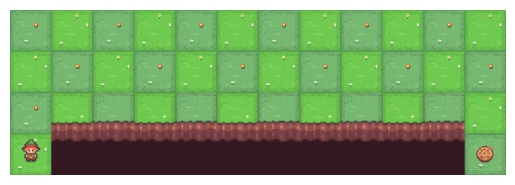

Step 0: observation=24, reward=-1, done=False


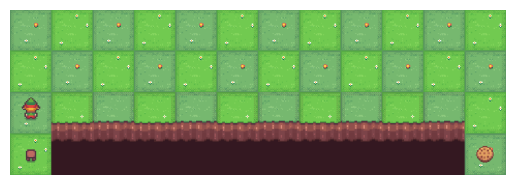

Step 1: observation=25, reward=-1, done=False


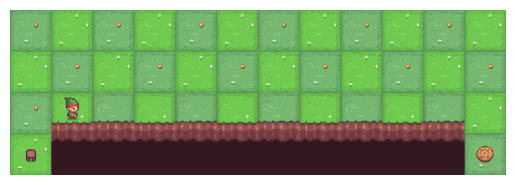

Step 2: observation=26, reward=-1, done=False


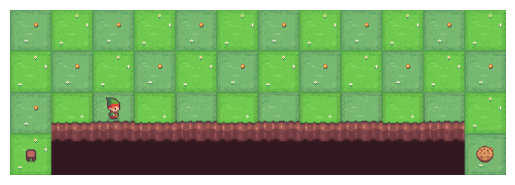

Step 3: observation=27, reward=-1, done=False


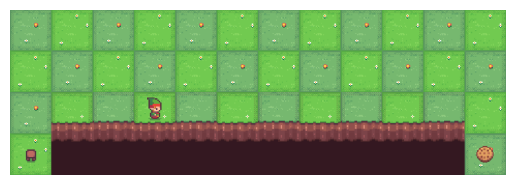

Step 4: observation=28, reward=-1, done=False


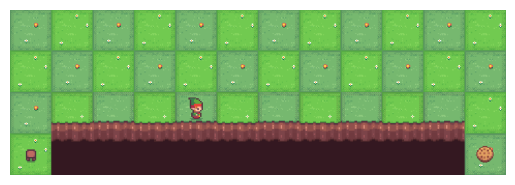

Step 5: observation=29, reward=-1, done=False


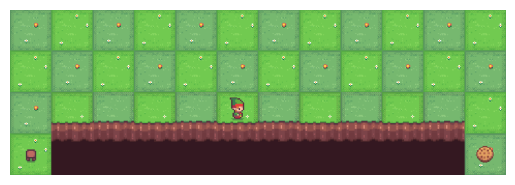

Step 6: observation=30, reward=-1, done=False


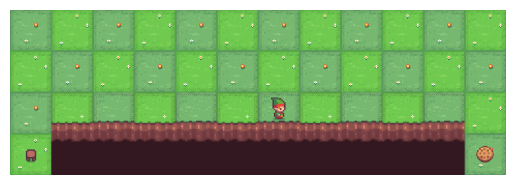

Step 7: observation=31, reward=-1, done=False


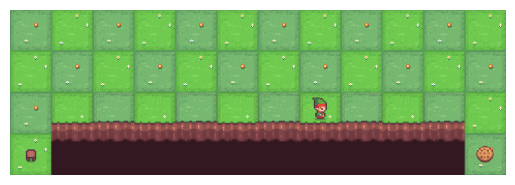

Step 8: observation=32, reward=-1, done=False


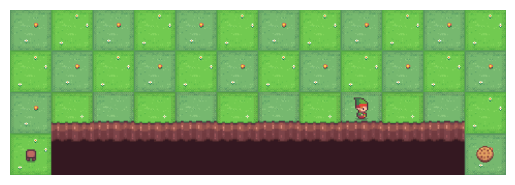

Step 9: observation=33, reward=-1, done=False


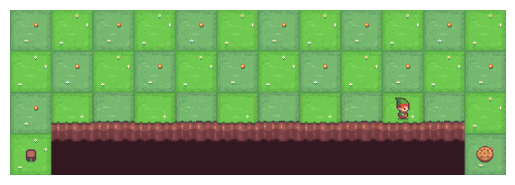

Step 10: observation=34, reward=-1, done=False


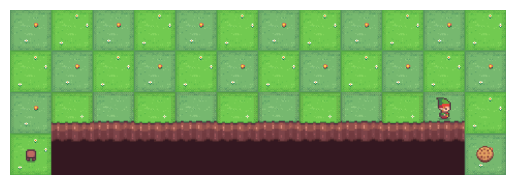

Step 11: observation=35, reward=-1, done=False


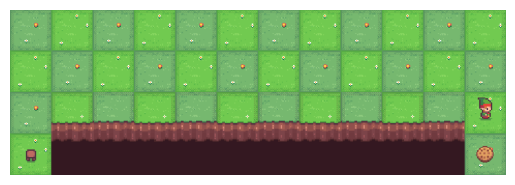

Step 12: observation=47, reward=-1, done=True
--------------------------------------------FINAL STATE---------------------------------------------


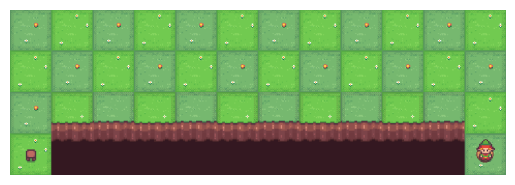

Final reward  -13.0
Moviepy - Building video cliff_walking_run.mp4.
Moviepy - Writing video cliff_walking_run.mp4



Moviepy - Done !
Moviepy - video ready cliff_walking_run.mp4


In [5]:
agent.follow_best_policy()

video_path = 'cliff_walking_run.mp4'

with open(video_path, 'rb') as video_file:
    video_data = b64encode(video_file.read()).decode()

video_tag = f'''
<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{video_data}" type="video/mp4">
    Your browser does not support the video tag.
</video>'''
HTML(video_tag)

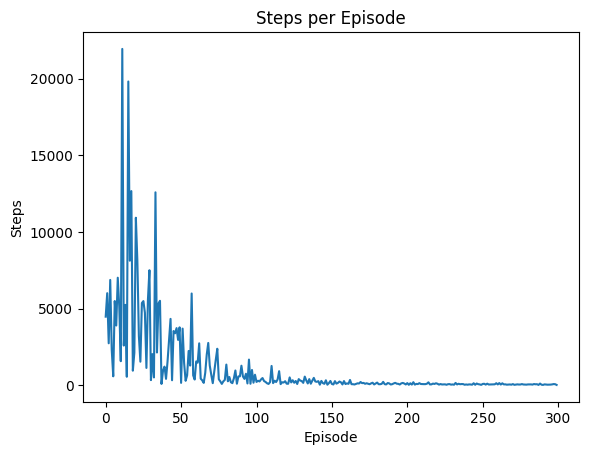

In [6]:
# Visualize number of steps required to reach the target in each epoch of learning
plt.plot(agent.steps_register)
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Steps per Episode')
plt.show()